<center><b>EE 538 Spring 2021<br>
Low-Noise Analog Circuit Design<br>
University of Washington Electrical & Computer Engineering</b></center>


<b>Instructor: Jason Silver<br>
Assignment #3 (10 points)<br>
Due Monday, April 26 (Submit on Canvas as a Jupyter Notebook)</b> 

*Please show your work*

<b>Problem 1: Low-noise common-emitter amplifier design

<center><img src="img/CE_EF_biasing.png" width=400 /></center>
<br>
<center><b>Figure 1a. Common-emitter amplifier with bias </b></center>

<center><img src="img/CE_EF_midband.png" width=250 /></center>
<br>
<center><b>Figure 1b. Equivalent "mid-band" circuit </b></center>

The common-emitter amplifier is often biased using the configuration shown in Figure 1a, where $R_{B1,2}$ are used to set the DC base voltage and $R_E$ is needed to stabilize the DC bias condition against variations in temperature and transistor parameters. $Q_2$ is added to form an emitter-follower for low output impedance. The DC emitter current of the common-emitter stage ($I_{E1}$ is determined by

\begin{equation}
I_E = \dfrac{V_B - V_{BE}}{R_E + \frac{R_B}{\beta_0+1}}
\end{equation}


where $R_B$ is the parallel combination of $R_{B1}$ and $R_{B2}$ and component values satisfy the conditions $V_B >> V_{BE}$  and $R_E >> R_B/(\beta_0 +1)$.

$C_{AC}$ and $C_{AC2}$ are used to realize low impedances at signal frequencies at the base and emitter nodes, resulting in the equivalent "mid-band" circuit shown in Figure 1b. 

<u>*Analysis*</u>

__a)__ Assuming $R_s = 0$ and ignoring transistor capacitances $C_\pi$ and $C_\mu$, use the small-signal equivalent circuit of the amplifier in Figure 1a to derive its transfer function in terms of $R$'s, $C$'s, and transistor parameters $g_m$, $r_o$, and $\beta_0$.

$\begin{eqnarray}
&& R_B &=& R_{B_1} \parallel R_{B_2} & \text{ (short DC voltages in AC analysis)} \\[0.5em]
&& Z_s &=& R_s + \frac{1}{sC_{AC}}  \\[0.5em]
&& Z_E &=& R_E \parallel \frac{1}{sC_{AC_2}} \\[0.5em]
&& r_b &=& 0 & \rightarrow v_{\pi} = v_{be} \\[0.5em]
&& r_{\pi} &=& \frac{v_{\pi}}{i_b} \approx \frac{v_{be}}{(g_m v_{be}) / \beta} = \frac{\beta_0}{g_m} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } v_{in}^\prime &&  \text{voltage divider } (R_{in} \parallel R_B) \text{ and} R_s  \\[0.5em]
&& v_{in}^\prime &=& \frac{(R_{in} \parallel R_B)}{(R_{in} \parallel R_B) + Z_s}V_s \\[0.5em]
&& \frac{v_{in}^\prime}{V_s} &=& \frac{(R_{in} \parallel R_B)}{(R_{in} \parallel R_B) + Z_s} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } R_{in} &&  \text{Common Emitter} \\[0.5em]
&& i_t &=& \frac{v_{be}}{r_{\pi}} \text{ (current from test voltage)} \\[0.5em]
&& v_t &=& v_{be} + Z_E(\frac{v_{be}}{r_{\pi}} + g_m v_{be}) \\[0.5em]
&& R_{in} &=& \frac{v_t}{i_t} \\[0.5em]
&&  &=& (v_{be} + Z_E(\frac{v_{be}}{r_{\pi}} + g_m v_{be})) \frac{r_{\pi}}{v_{be}} \\[0.5em]
&&  &=&  r_{\pi} + Z_E + Z_E g_m r_{\pi} \\[0.5em]
&& &\approx&  r_{\pi}(1 + g_m Z_E)  \\[0.5em]
&&  \lim_{s \to \infty} R_{in} &=& r_{\pi} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } R_{out_1} &&  \text{Common Emitter} \\[0.5em]
&& R_{out_1} &=& R_C \parallel r_0 (1+g_m R_E) \\[0.5em]
&& &\approx& R_C \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } V_{out_1} &&  \text{Common Emitter} \\[0.5em] \\[0.5em]
&& v_{in}^\prime &=& v_{be} + Z_E(g_m v_{be} + \frac{v_{be}}{r_{\pi}}) \\[0.5em]
&& &=& v_{be}(1 + Z_E(g_m + \frac{1}{r_{\pi}})) \\[0.5em]
&& &\approx& v_{be}(1 + g_m Z_E ) \\[0.5em]
&& V_{out_1} &=& -g_m v_{be} R_C \\[0.5em]
&& \frac{V_{out_1}}{v_{in}^\prime} &=& \frac{-g_m R_C}{1 + g_m Z_E} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } v_{in_2}^\prime &&   \text{Emitter Follower}  \\[0.5em]
&& v_{in_2}^\prime &=& \frac{R_{in_2}}{R_{in_2} + R_{out_1}} V_{out_1} \\[0.5em]
&& \frac{v_{in_2}^\prime}{V_{out_1}} &=& \frac{R_{in_2}}{R_{in_2} + R_{out_1}}  \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } R_{in_2} &&  \text{Emitter Follower} \\[0.5em]
&& R_{in_2} &=& r_{\pi} (1 + g_m R_{E_2}) \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } V_{out_2} &&  \text{Emitter Follower} \\[0.5em]
&& \frac{V_{out_2}}{v_{in_2}^\prime} &=& \frac{g_m R_{E_2}}{1+g_m R_{E_2}} \\[0.5em]
\end{eqnarray}$

<hr>

$\begin{eqnarray}
&& \text{ Find } V_{out_2} &&  \\[0.5em]
&& \frac{V_{out_2}}{V_s} &=& \frac{v_{in}^\prime}{V_s} \cdot \frac{V_{out_1}}{v_{in}^\prime} \cdot \frac{v_{in_2}^\prime}{V_{out_1}}  \cdot \frac{V_{out_2}}{v_{in_2}^\prime}\\[0.5em]
&& \frac{V_{out_1}}{V_s} &=& \frac{(R_{in} \parallel R_B)}{(R_{in} \parallel R_B) + Z_s} \cdot \frac{-g_m R_C}{1 + g_m Z_E} \cdot \frac{R_{in_2}}{R_{in_2} + R_{out_1}} \cdot \frac{g_m R_{E_2}}{1+g_m R_{E_2}} \\[0.5em] 
&& &=& \frac{(r_{\pi}(1 + g_m Z_E) \parallel R_B)}{(r_{\pi}(1 + g_m Z_E) \parallel R_B) + Z_s} \cdot \frac{-g_m R_C}{1 + g_m Z_E} \cdot \frac{r_{\pi} (1 + g_m R_{E_2})}{r_{\pi} (1 + g_m R_{E_2}) + R_C} \cdot \frac{g_m R_{E_2}}{1+g_m R_{E_2}} &\text{ where } r_{\pi} = \frac{\beta_0}{g_m} \\[0.5em]
\end{eqnarray}$

<hr>

__b)__ Determine expressions for the input-referred noise sources $e_n$ and $i_n$ of the amplifier in Figure 1b assuming only thermal and shot noise generators (no $1/f$ noise or $f_T$-dependent shot noise).

<img src="img/CE_noise_model.png" width=600 />

$\begin{eqnarray}
&& r_e &=& \frac{1}{g_m} = \frac{V_T}{I_C} \\[0.5em]
&& e_n^2 &=& 4kT\left(r_{b} + \dfrac{r_e}{2} + \dfrac{r_e^2}{R_C} + \dfrac{r_e^2}{R_{in_2}}\right) = 4kT\left(r_{b} + \dfrac{1}{2g_m} + \dfrac{1}{g_m^2R_C} + \dfrac{1}{g_m^2 R_{in_2}}\right) \\[0.5em]
&& e_n &=& \sqrt{4kT\left(r_{b} + \dfrac{r_e}{2} + \dfrac{r_e^2}{R_C} + \dfrac{r_e^2}{R_{in_2}}\right)} = \sqrt{4kT\left(r_{b} + \dfrac{1}{2g_m} + \dfrac{1}{g_m^2R_C} + \dfrac{1}{g_m^2 R_{in_2}}\right)} \\[0.5em]
&& i_n^2 &=& 2q\dfrac{I_C}{\beta_0} \\[0.5em]
&& i_n &=& \sqrt{2q\dfrac{I_C}{\beta_0}} \\[0.5em]
&& NF &=& 1 + \frac{e_n^2 + i_n^2 R_S^2}{4kTR_S}
\end{eqnarray}$

<hr>

<u>*Design*</u>

__c)__ Assuming $R_s$ = $100\Omega$, $r_b = 2\Omega$ and $\beta_0 = 250$, what is the minimum theoretical noise figure of the amplifier? What value of $I_{C1}$ does this correspond to? Assume a mid-band gain of the common-emitter stage of $40\text{dB}$ and an output impedance of the emitter-follower of $50\Omega$. 

Minimum theoretical noise figure of the amplifier is 1.07

$\begin{eqnarray}
&& NF &=& 1 + \frac{e_n^2 + i_n^2 R_S^2}{4kTR_S} \\[0.5em]
&&  &=& 1 + \frac{4kT(r_b + \frac{V_T}{2I_C}) + 2q\frac{I_c}{\beta_0}R_S^2}{4kTR_S} \\[0.5em]
&&  &=& 1 + \frac{4kT \cdot r_b}{4kTR_S} + \frac{4kT \cdot V_T}{4kTR_S \cdot 2I_C} + \frac{2q R_S I_c}{4kT \cdot \beta_0} \\[0.5em]
&& \frac{\partial NF}{\partial I_C} &=& \frac{\partial}{\partial I_C} (1 + \frac{4kT \cdot r_b}{4kTR_S} + \frac{4kT \cdot V_T}{4kTR_S \cdot 2I_C} + \frac{2q R_S I_c}{4kT \cdot \beta_0}) \\[0.5em]
&& 0 &=& \frac{\partial}{\partial I_C} (\frac{V_T}{2R_S}\frac{1}{I_C} + \frac{R_S}{2V_T  \beta_0}I_c) \\[0.5em]
&& 0 &=& \frac{-V_T}{2R_S}\frac{1}{I_C^2} + \frac{R_S}{2V_T \beta_0} \\[0.5em]
&& \frac{V_T}{2R_S}\frac{1}{I_C^2} &=&  \frac{R_S}{2V_T \beta_0} \\[0.5em]
&& \frac{2 V_T^2 \beta_0}{2R_S^2} &=&  I_C^2  \\[0.5em]
&& \beta_0 \frac{V_T^2 }{R_S^2} &=&  I_C^2  \\[0.5em]
&& I_C &=& \sqrt{\beta_0} \frac{V_T}{R_S} \\[0.5em]
&& &=& \sqrt{250} \frac{26\cdot 10^{-3}}{1000} = 411 \mu A \\[0.5em]
\end{eqnarray}$

In [4]:
R_s,r_b,beta_0,I_C = sp.symbols('R_s,r_b,beta_0,I_C')
k = 1.38e-23
T = 300
q = 1.602e-19
V_T = k*T/q

I_Cs = np.linspace(100*1e-6,1.5*1e-3, num=100)

en_sq = 4*k*T*(V_T/(2*I_C) + r_b)
in_sq = 2*q*I_C/beta_0
NF = 1 + (en_sq + in_sq*R_s**2)/(4*k*T*R_s)

components = {
    R_s : 1000,
    r_b : 2,
    beta_0 : 250,
}
H = sp.Matrix([NF])
H = H.subs(components)
H = lambdify(I_C,H,modules='numpy')
H = H(I_Cs)
H = H[0][0]

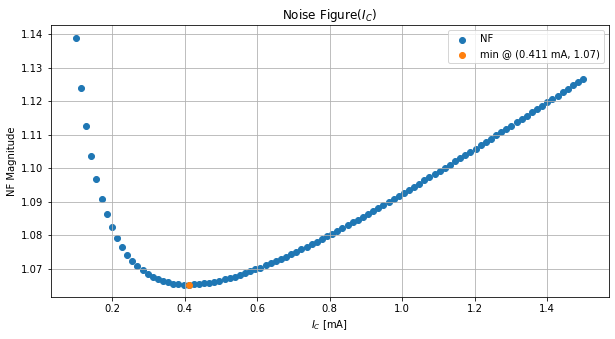

In [5]:
fig, ax = plt.subplots(figsize=(10,5))

label = f'min @ ({rnd(I_Cs[np.argmin(H)],3,"mA")} mA, {round(min(H),2)})'

ax.set_title(r'Noise Figure($I_C$)')
ax.scatter(I_Cs*1e3, H,label=r'NF')
ax.scatter(I_Cs[np.argmin(H)]*1e3, min(H), label=f'{label}')
ax.set_ylabel('NF Magnitude')
ax.set_xlabel(r'$I_C$ [mA]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

<hr>

__d)__ Design the amplifier (i.e. determine resistor values $R_{B1,2}$, $R_E$, $R_C$, and $R_{E2}$) for a mid-band gain of $40\text{dB}$ and the noise figure determined in part c. Use a supply voltage $V_{CC} = 9V$. Determine values for $C_{AC}$ and $C_{AC2}$ that ensure a $3\text{dB}$ highpass corner lower than $100\text{Hz}$.

Verify your design in Ltspice using the SPICE model of the 2SC3324 npn transistor from Toshiba. Include an image of your schematic (with DC node voltages and branch currents annotated) and plots of the frequency response, output noise, and noise figure as a function of frequency. Indicate the noise figure at $10\text{kHz}$.

DC Analysis

<br>
Given
<br>

$\begin{eqnarray}
&& I_E &=& \dfrac{V_B - V_{BE}}{R_E + \frac{R_B}{\beta_0+1}} \\[0.5em]
\end{eqnarray}$

$\begin{eqnarray}
g_m &\equiv& \dfrac{\partial I_C}{\partial V_{BE}} = \dfrac{qI_C}{kT} = \dfrac{I_C}{V_T}  \\[0.5em]
r_o &\equiv& \dfrac{\partial V_{CE}}{\partial I_C} = \dfrac{V_A}{I_C} \\[0.5em]
r_\pi &=& \beta_0 \dfrac{V_T}{I_C} = \dfrac{\beta_0}{g_m} \\[0.5em]
\end{eqnarray}$

$\begin{eqnarray}
&& I_B &=& \frac{I_C}{\beta} \\[0.5em]
&& I_E &=& I_B + I_C \\[0.5em]
&& I_E &=& (1+\beta) I_B \\[0.5em]
\end{eqnarray}$

<hr>

Set $I_C$ to minimize noise. I'm setting $I_C = 0.5$ mA. Will update if have time.
<br>
Choose $V_C$ to be midpoint of $V_{CC}$ and ground. $V_C = 4.5$ 
<br>
Find $R_C$
<br>

$\begin{eqnarray}
&& I_C &=& \frac{V_{CC}-V_C}{R_C} \\[0.5em]
&& R_C &=& \frac{V_{CC}-V_C}{I_C} \\[0.5em]
&& &=& \frac{9-4.5}{0.5mA} \\[0.5em]
&& &=& 9000 \Omega \\[0.5em]
\end{eqnarray}$

<br>
Find transconductance $g_m$
<br>

$\begin{eqnarray}
&& V_T &\approx& 26mV \\[0.5em]
&& g_m &=& \frac{I_C}{V_T} \\[0.5em]
&& g_m &=& \frac{0.5mA}{26mV} \\[0.5em]
&& &=& 0.019 \\[0.5em]
\end{eqnarray}$

<hr>

Find $V_{th}$ and $R_{th}$

$\begin{eqnarray}
&& V_{th} &=& V_{CC} \frac{R_{B_2}}{R_{B_2} + R_{B_1}} \\[0.5em]
&& R_{th} &=& R_{B_1} \parallel R_{B_2} \\[0.5em]
\end{eqnarray}$

<hr>

Choose $Z_{in}$ to be large; 5K

$\begin{eqnarray}
&& Z_{in} &=& 5K \Omega \\[0.5em]
&& Z_{in} &=& R_{th} \parallel r_{\pi} \\[0.5em]
&& 5000 &=& R_{th} \parallel \frac{\beta_0}{g_m} \\[0.5em]
&& 5000 &=& R_{th} \parallel \frac{250}{0.019} \\[0.5em]
&& 5000 &=& \frac{R_{th} \cdot 13157}{R_{th}+13157}  \\[0.5em]
&& R_{th} &=& 8065 \Omega \\[0.5em]
\end{eqnarray}$

<hr>

<br>
Apply KVL
<br>

$\begin{eqnarray}
&& -V_{th} + I_B R_{th} + V_{BE} + I_E R_E \\[0.5em]
&& I_B (R_{th} + R_E (1 + \beta)) = V_{th} - V_{BE} \\[0.5em]
&& I_B = \frac{V_{th} - V_{BE}}{R_{th} + R_E (1 + \beta)} \\[0.5em]
&& I_E = (\beta_0+1)I_B \\[0.5em]
&& I_E = \dfrac{V_B - V_{BE}}{R_E + \frac{R_B}{\beta_0+1}} \approx \frac{V_B}{R_E}\\[0.5em]
&& I_C \approx I_E \\[0.5em]
&&  \text{then}  \\[0.5em]
&& \frac{V_B}{R_E} = 0.5mA \\[0.5em]
\end{eqnarray}$

Choose $V_B = 6V$, then $R_E$ = $12K\Omega$

Solving $V_{th}$ and $R_{th}$ simultaneously results

$\begin{eqnarray}
R_{B_1} = 16130 \\[0.5em]
R_{B_2} = 16130 \\[0.5em]
\end{eqnarray}$

<hr>

AC Analysis


$\begin{eqnarray}
&& \frac{V_{out}}{V_s} &=& 40dB \\[0.5em]
&& V_{be} &=& \frac{V_{s} R_{th}}{R_s + R_{th}} \\[0.5em]
&& \frac{V_{out}}{V_s} &=& \frac{V_{be}}{V_{s}} \cdot \frac{V_{out}}{V_{be}} \cdot \frac{R_{in_2}}{R_{out_1} + R_{in_2}} \\[0.5em]
&& 40dB &=& \frac{ R_{th}}{R_s + R_{th}} \cdot -g_m R_C \cdot \frac{R_{in_2}}{R_C + R_{in_2}} \\[0.5em]
&& 10000 &=& \frac{8065}{1000 + 8065} \cdot -0.019 \cdot 9000 \cdot \frac{R_{in_2}}{9000 + R_{in_2}} \\[0.5em]
&& R_{in_2} &=& 8865 \\[0.5em]
\end{eqnarray}$

<hr>

Find $R_{in_2}$

$\begin{eqnarray}
&& R_{in_2} &=& r_{\pi}(1 + g_m R_{E_2}) \approx \beta_0 R_{E_2} \\[0.5em]
&& 8865 &=& 250 R_{E_2} \\[0.5em]
&& R_{E_2} &=& 35 \Omega \\[0.5em]
\end{eqnarray}$


<img src="img/LTspice_Model.png" width=700 />

<img src="img/DC_operating_point.png" width=600 />

In [6]:
filepath = 'data/HW03.txt'
df = read_ltspice(filepath,'ac')
freq = df['Freq.']
mag = df['Mag_V(vout2)/I(vs)']

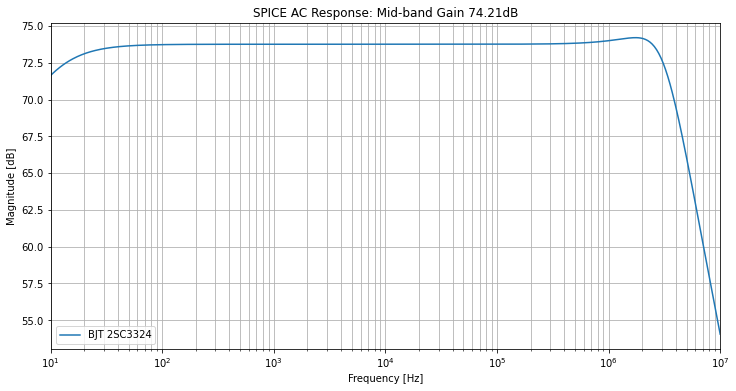

In [7]:
fig, ax = plt.subplots(1,figsize=(12,6))

ax.semilogx(freq, mag, color='tab:blue',label='BJT 2SC3324')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title(f'SPICE AC Response: Mid-band Gain {round(max(mag),2)}dB')
ax.set_xlim(1e1,1e7)

ax.legend()
plt.show();

In [8]:
filepath = 'data/HW03_noise.txt'
df = pd.read_csv(filepath)
freq = df['frequency']
onoise = df['V(onoise)']
inoise = df['V(inoise)']

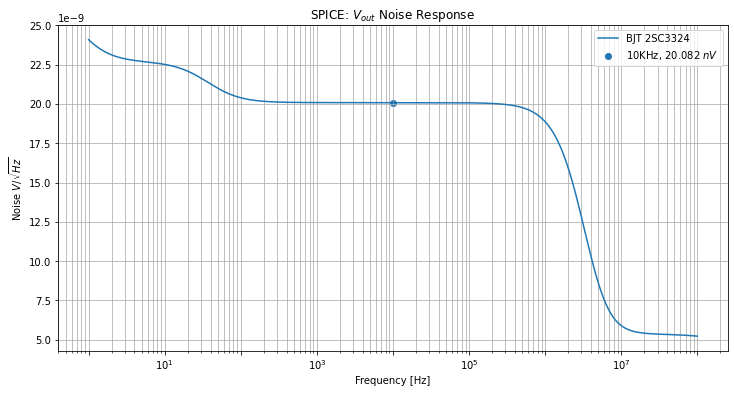

In [9]:
fig, ax = plt.subplots(1,figsize=(12,6))

x1 = np.where(freq<=10000)[0][-1]
label1 = r"10KHz, {:.3f} $nV$".format(onoise[x1]*1e9)

ax.semilogx(freq, onoise, color='tab:blue',label='BJT 2SC3324')
ax.scatter(freq[x1],onoise[x1],label=label1,color='tab:blue')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise $V/\sqrt{Hz}$')
ax.set_title(r'SPICE: $V_{out}$ Noise Response')
ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
#ax.set_ylim(10e-9,50e-9)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

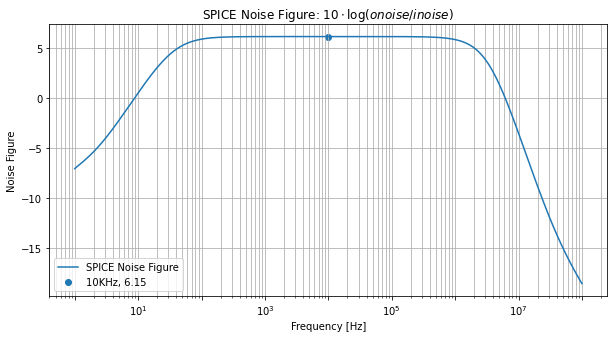

In [10]:
fig, ax = plt.subplots(1,figsize=(10,5))

x1 = np.where(freq<=10000)[0][-1]
label1 = r"10KHz, {:.2f}".format(10*np.log10(onoise[x1]/inoise[x1]))

ax.semilogx(freq, 10*np.log10(onoise/inoise), color='tab:blue',label='SPICE Noise Figure')
ax.scatter(freq[x1],10*np.log10(onoise[x1]/inoise[x1]),label=label1,color='tab:blue')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Noise Figure')
ax.set_title(r'SPICE Noise Figure: $10\cdot \log(onoise/inoise)$')
#ax.ticklabel_format(style='sci', axis='y', scilimits=(-9,-9))
#ax.set_ylim(10e-9,50e-9)

# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();

### Reference Page

In [11]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [12]:
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs,dtype='float64')
    df = df.T
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [13]:
def rnd(num,places,unit):
    if unit.lower()=='mhz':
        return round(num/(1e6),places)
    if unit.lower()=='ma':
        return round(num/(1e-3),places)